In [1]:
random_state = 9999
image_output_params = {'width': 1080, 'height': 600, 'scale': 6}
render = 'svg' #or None to have interactive plots

# Machine-Learning
Set-up

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/clean_listing.csv', index_col=0)
# Split data and drop unnecessary data
Y = df['price']
X = df.drop(['price', 'latitude', 'longitude'], axis=1)
X = X.astype('float64')
X.head()
# Storage
result = {'Method':[], 'Train R2':[], 'Train RMSE':[], 'Test R2': [], 'Test RMSE': []}

In [4]:
f"The standard deviation of price of listing is ${df['price'].std():.2f}."

'The standard deviation of price of listing is $132.36.'

In [5]:
def update_frame(frame: dict, y_train, y_train_pred, y_true, y_pred, method_name):
    frame['Method'].append(method_name)
    frame['Train R2'].append(r2_score(y_train, y_train_pred))
    frame['Train RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    frame['Test R2'].append(r2_score(y_true, y_pred))
    frame['Test RMSE'].append(np.sqrt(mean_squared_error(y_true, y_pred)))

def calculate_score(y_true, y_pred):
    print(f"R2 Score {r2_score(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")

def plot(y_true, y_pred, title, band=True):
    # Plotly express plot
    h = pd.DataFrame(data={'Actual y':y_true, 'Predicted y': y_pred})
    RMSE = df['price'].std()

    fig = px.scatter(h, x='Actual y', y='Predicted y', title=title)
    fig.add_trace(go.Scatter(x=[0, 600],y=[0, 600],mode="lines",line=go.scatter.Line(color='gray'),showlegend=False)) #Diagonal Line
    if band:
        fig.add_traces([
            go.Scatter(x=[0, 600],y=[0+RMSE, 600+RMSE],mode='lines',line=go.scatter.Line(dash='dot'),showlegend=False),
            go.Scatter(x=[0, 600],y=[0-RMSE, 600-RMSE],mode='lines',line=go.scatter.Line(dash='dot'),showlegend=False)
            ])
    fig.show(render)
    return fig

def simulate(model, XXyy, name: str):
    # Model must be fitted and implement predict, score methods.
    # XXyy: X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = XXyy
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    update_frame(result, y_train, y_train_pred, y_test, y_pred, name)

    print(f"Train\n Score: {model.score(X_train, y_train)}")
    calculate_score(y_train, y_train_pred)

    print(f"Test\n Score: {model.score(X_test, y_test)}")
    calculate_score(y_test, y_pred)
    
    fig = plot(y_test, y_pred, name)
    fig.write_image(f'images/{name}.png', **image_output_params)

def feature_plot(feature_name, feature_score, name: str):
    feature_importance = pd.DataFrame({'Feature': feature_name, 'Score': feature_score})
    feature_importance.sort_values(by='Score', axis=0, inplace=True, ascending=False)

    fig = px.bar(feature_importance.head(20), x='Score', y='Feature', orientation='h')

    fig.update_layout(title={'text': f'{name} Most Relevant Feature'})
    fig.show(render)
    fig.write_image(f'images/{name} Most Relevant Feature.png', **image_output_params)

    fig = px.bar(feature_importance.tail(20), x='Score', y='Feature', orientation='h')
    fig.update_layout(title={'text': f'{name} Least Relevant Feature'})
    fig.show(render)
    fig.write_image(f'images/{name} Least Relevant Feature.png', **image_output_params)
        

# Part 1:
Finding a model that best predicts price. We will being trying :
- linear model: Linear Regression
- tree-based model: HistGradientBoostRegressor, XGBoost
- and to try something new: Neural Network.

We will be using $R^2$ score to compare the goodness of the model, and RMSE to find the accuracy of the prediction.

### Model 1: Linear Regression

We first use linear regression, a method taught for predicting numerical values.

In [6]:
XXyy = X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

Train
 Score: 0.6185228181568949
R2 Score 0.6185228181568949
RMSE : 82.29618881032178
Test
 Score: 0.5779888564116571
R2 Score 0.5779888564116571
RMSE : 83.35227735073117


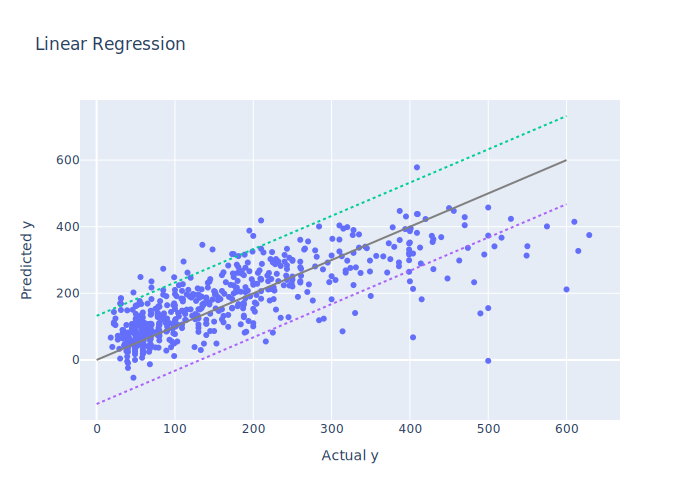

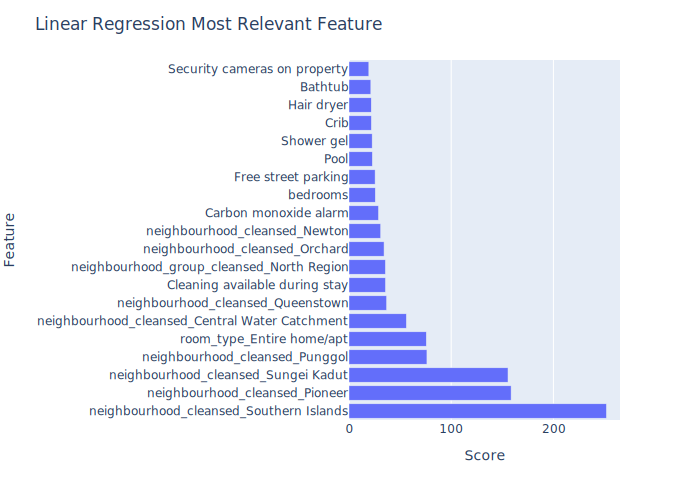

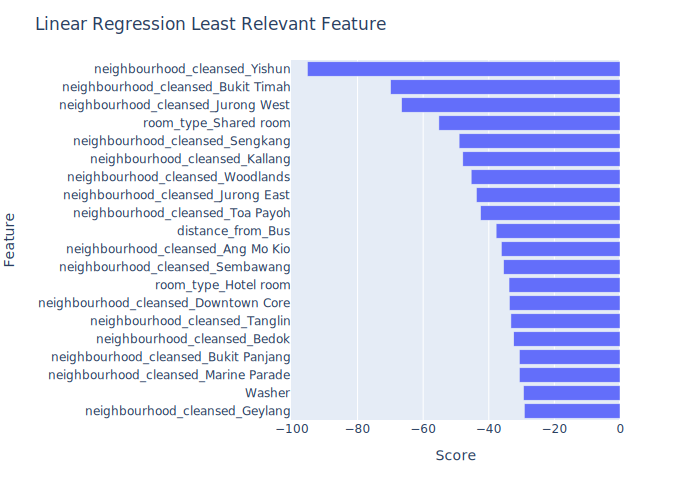

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

simulate(model, XXyy, 'Linear Regression')
feature_plot([col for col in X.columns], [model.coef_[i].round(5) for i in range(len(X.columns))], 'Linear Regression')

### Model 2: Gradient Boost Regressor

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will be using HistGradientBoostingRegressor from sklearn.

Train
 Score: 0.9999217830187603
R2 Score 0.9999217830187603
RMSE : 1.178408769113613
Test
 Score: 0.7147757332953467
R2 Score 0.7147757332953467
RMSE : 68.52495306058684


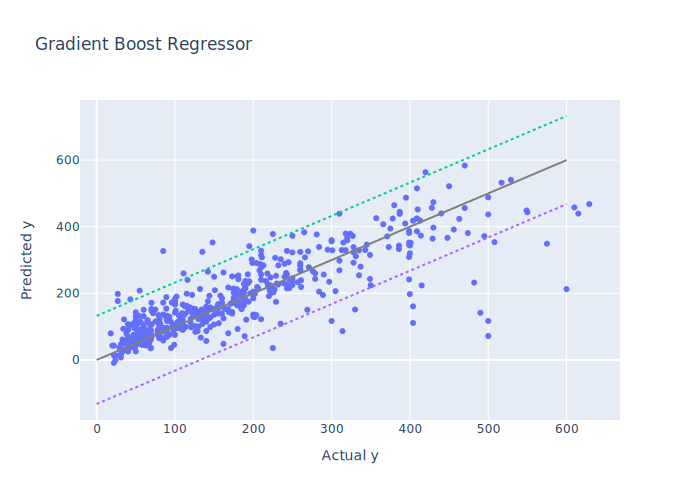

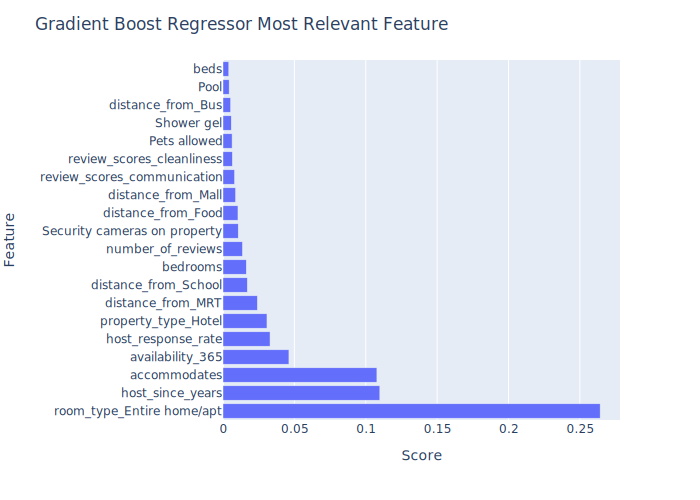

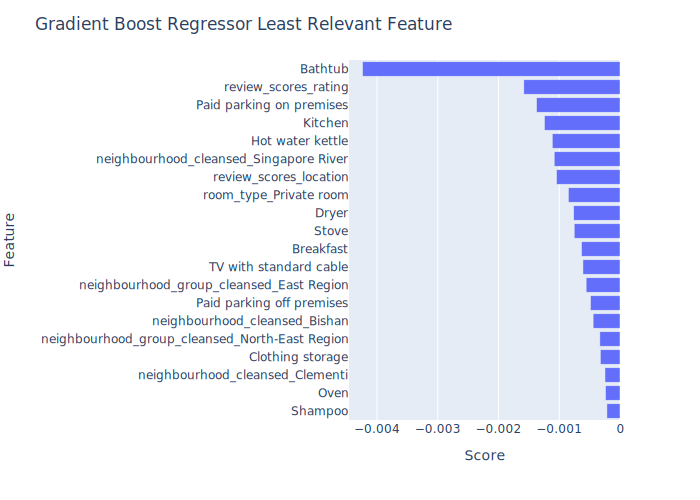

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=random_state, max_iter=1000)

model.fit(X_train, y_train)

simulate(model, XXyy, name='Gradient Boost Regressor')

feature_plot(model.feature_names_in_, 
             permutation_importance(model, X_test, y_test, random_state=random_state).importances_mean, 
             'Gradient Boost Regressor')

### Model 3: XGBoost Regression

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will use XGBoost API to do the model fitting.

Train
 Score: 0.9904317474468289
R2 Score 0.9904317474468289
RMSE : 13.033520980706674
Test
 Score: 0.705241733013719
R2 Score 0.705241733013719
RMSE : 69.66080804119946


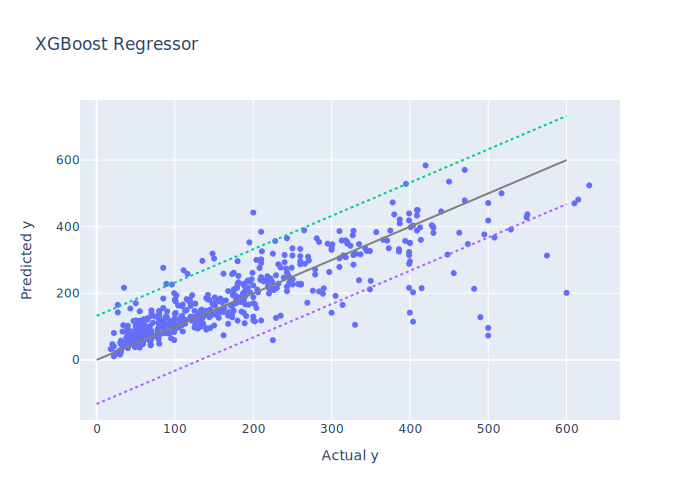

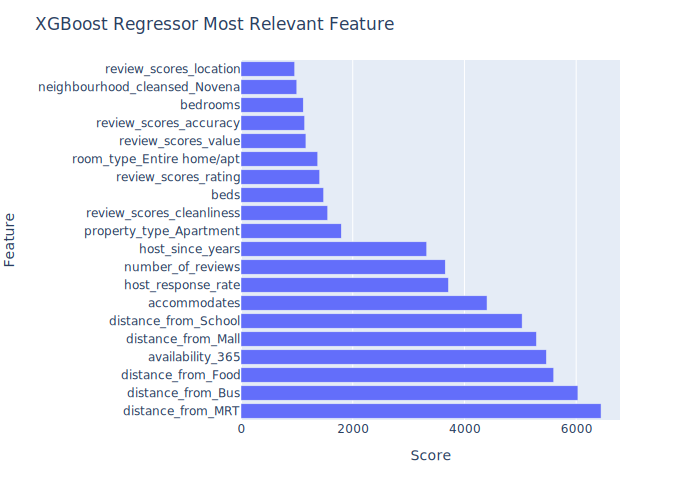

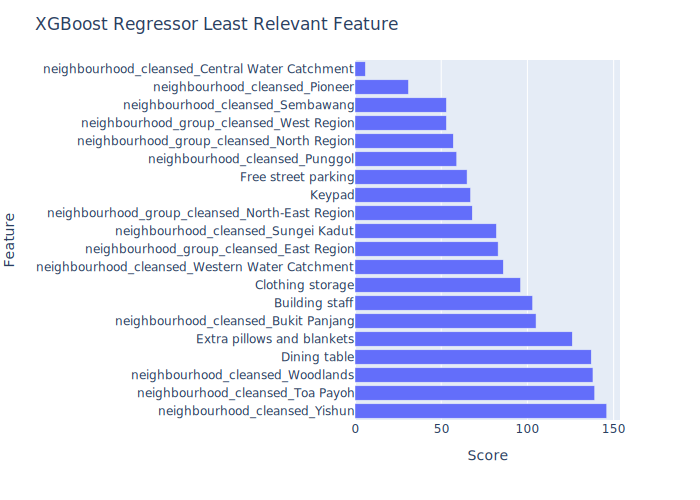

In [9]:
import xgboost as xgb

model = xgb.sklearn.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators = 2500,
                         learning_rate=0.01, random_state=random_state)

model.fit(X_train, y_train)

simulate(model, XXyy, 'XGBoost Regressor')

booster = model.get_booster()
feature_plot(booster.get_score().keys(), booster.get_score().values(), 'XGBoost Regressor')

### Model 4: Neural Networks

We will be using Sklearn MLPRegressor, short for Multi-layer Perception Regressor. Model optimizes for lowest squarer error by gradient descent.

Train
 Score: 0.7678853210043803
R2 Score 0.7678853210043803
RMSE : 64.19434079879785
Test
 Score: 0.6443170607563389
R2 Score 0.6443170607563389
RMSE : 76.5221260462495


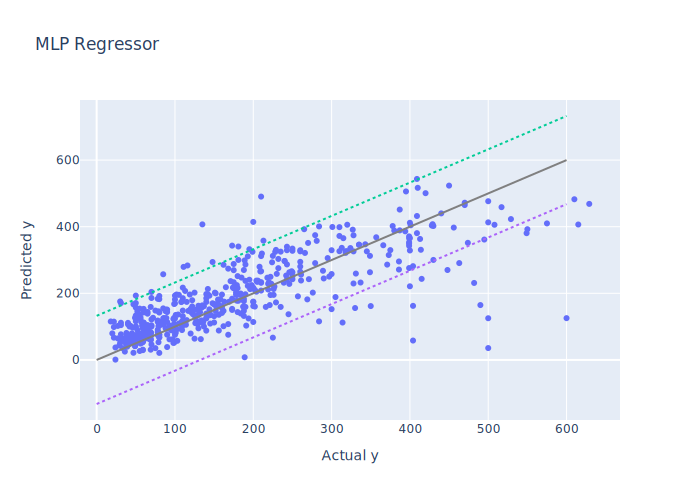

In [10]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=random_state, max_iter=1000).fit(X_train, y_train)

simulate(model, XXyy, 'MLP Regressor')

We can conclude that HistGradientBoostingRegressor and XGBoost Regressor achieve the best results, with the lowest RMSE (~65) and the higher R^2 score (~0.74). All other models achieve decent results, with RMSE around half of standard deviation, and R^2 > 0.5.

# Part 2: Optimising models

We will be using RandomizedSearchCV, GridSearchCV to find the optimal parameters.
- Benefit: Can finds optimal values between the 'grid' in a GridSearchCV, do not need prior experience & intuition.
- Downside: Takes significantly longer to find optimal values.

In [11]:
from scipy.stats import loguniform
# Code from scikit-learn-mooc
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = HistGradientBoostingRegressor(random_state=random_state)

param_distributions = {
    'max_bins': loguniform_int(2, 255),
    'max_leaf_nodes': loguniform_int(2, 256),
    'min_samples_leaf': loguniform_int(1, 100),
    'learning_rate': loguniform(0.001, 10),
}

cv = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=350, cv=3, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2'], refit='r2') .fit(X_train, y_train)

v = pd.DataFrame(cv.cv_results_)
v.sort_values(by='rank_test_r2', inplace=True)
display(v.head(10))

print(f"Best parameters: {cv.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_bins,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_neg_mean_squared_error,...,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
67,0.391084,0.020939,0.009688,0.001559,0.097615,9,43,5,"{'learning_rate': 0.09761465309263373, 'max_bi...",-4537.935886,...,-4036.032946,-4784.477285,732.791058,1,0.738076,0.701126,0.752200,0.730467,0.021534,1
41,0.399235,0.025200,0.006593,0.001878,0.075832,44,34,6,"{'learning_rate': 0.07583212284884161, 'max_bi...",-4440.602926,...,-4131.708434,-4798.298616,735.175767,2,0.743693,0.698896,0.746326,0.729638,0.021765,2
132,0.593669,0.015882,0.007811,0.001660,0.044078,26,54,3,"{'learning_rate': 0.04407812055192615, 'max_bi...",-4520.740929,...,-4191.021620,-4822.073003,672.895677,3,0.739068,0.702419,0.742685,0.728057,0.018189,3
11,0.658034,0.005512,0.012175,0.002963,0.073874,60,232,15,"{'learning_rate': 0.07387424943661276, 'max_bi...",-4459.921567,...,-4216.518708,-4838.829728,714.908443,4,0.742578,0.697992,0.741119,0.727230,0.020683,4
149,0.678908,0.017527,0.013599,0.001445,0.046794,16,237,12,"{'learning_rate': 0.04679360642280277, 'max_bi...",-4579.568156,...,-4121.810676,-4857.884581,741.227038,6,0.735673,0.696326,0.746934,0.726311,0.021695,5
324,0.465992,0.011314,0.011761,0.003162,0.107498,5,59,11,"{'learning_rate': 0.10749824266630963, 'max_bi...",-4577.122646,...,-4463.579955,-4857.847445,479.537227,5,0.735814,0.713879,0.725950,0.725214,0.008970,6
267,0.489523,0.002377,0.010100,0.002094,0.079533,63,73,25,"{'learning_rate': 0.07953306815681593, 'max_bi...",-4448.120335,...,-4232.566845,-4884.553616,774.643783,7,0.743260,0.691119,0.740134,0.724837,0.023877,7
314,0.350509,0.007867,0.008066,0.000510,0.065735,17,25,12,"{'learning_rate': 0.06573530930088932, 'max_bi...",-4447.057562,...,-4353.124080,-4910.008839,722.151890,8,0.743321,0.693349,0.732732,0.723134,0.021500,8
335,0.684458,0.067206,0.010572,0.006861,0.056444,122,33,5,"{'learning_rate': 0.05644424605205154, 'max_bi...",-4499.924837,...,-4213.889495,-4926.004128,813.251954,9,0.740269,0.686401,0.741281,0.722650,0.025635,9
95,1.240735,0.019899,0.009880,0.000856,0.067472,157,98,6,"{'learning_rate': 0.0674717226554725, 'max_bin...",-4441.235450,...,-4373.143393,-4936.775277,749.463215,10,0.743657,0.689930,0.731503,0.721697,0.023004,10


Best parameters: {'learning_rate': 0.09761465309263373, 'max_bins': 9, 'max_leaf_nodes': 43, 'min_samples_leaf': 5}


We can see that parameters with rank 1 has higher R^2 score. 

Note that due to cross-validation, R^2 score in GridSearchCV is lower than the above example, however it still shows the better parameters.

Train
 Score: 0.9739553116586473
R2 Score 0.9739553116586473
RMSE : 21.50329548941711
Test
 Score: 0.7159237983472057
R2 Score 0.7159237983472057
RMSE : 68.38690304506386


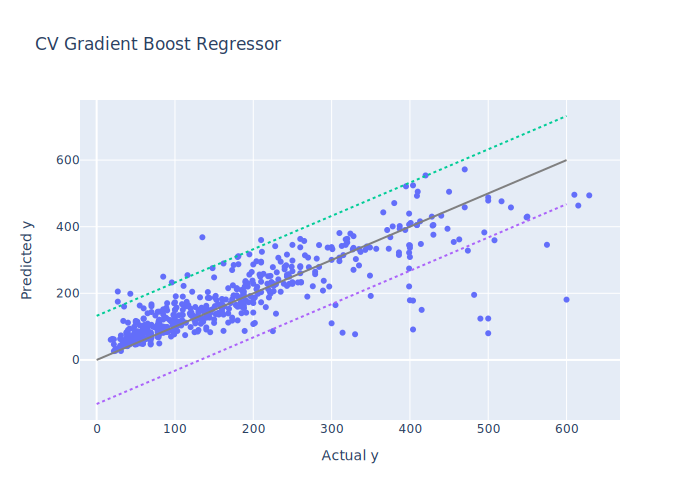

In [13]:
model = HistGradientBoostingRegressor(**cv.best_params_, random_state=random_state).fit(X_train, y_train)
simulate(model, XXyy, 'CV Gradient Boost Regressor')

### Tuning XGBoost Regressor

Parameters to tune:
- n estimators & learning_rate: Takes longer to achieve same error reduction, however smaller steps taken means we can find the optimal minimum
- max_leaves (default 0): By restricting max leaves, we can reduce overfitting.
- colsample_bytree (default 1): Fraction of columns to be randomly sampled, might reduce overfitting.
- subsample (default 1): Fraction of observations to sample for each tree, lower values reduce overfitting.

In [14]:
model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', seed=random_state)

params_grid = {
    'n_estimators': [1000, 1500],
    'learning_rate': [0.03, 0.05],
    'max_leaves': [0, 20, 40, 60, 80],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'subsample': [0.6, 0.8, 1],
}

cv = GridSearchCV(estimator=model, param_grid=params_grid, cv=3, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2'], refit='r2').fit(X_train, y_train)

v = pd.DataFrame(cv.cv_results_)
v.sort_values(by='rank_test_r2', inplace=True)
display(v.head(10))

print(f"Best parameters: {cv.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_leaves,param_n_estimators,param_subsample,params,...,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
148,5.248365,0.048384,0.043863,0.002015,0.8,0.03,80,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4044.481980,-4545.737941,647.482139,1,0.761463,0.717646,0.751682,0.743597,0.018780,1
124,6.104144,0.079927,0.049466,0.004933,0.8,0.03,0,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4044.481980,-4545.737941,647.482139,1,0.761463,0.717646,0.751682,0.743597,0.018780,1
145,3.555964,0.102098,0.032322,0.001457,0.8,0.03,80,1000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4043.879369,-4547.912513,648.043909,3,0.761214,0.717501,0.751719,0.743478,0.018773,3
121,4.099803,0.090040,0.035465,0.002037,0.8,0.03,0,1000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4043.879369,-4547.912513,648.043909,3,0.761214,0.717501,0.751719,0.743478,0.018773,3
142,5.431990,0.132894,0.049495,0.009073,0.8,0.03,60,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4003.070719,-4554.022164,675.948355,5,0.760296,0.715266,0.754224,0.743262,0.019951,5
139,3.702972,0.064178,0.031647,0.001914,0.8,0.03,60,1000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4008.296628,-4557.231120,676.024889,6,0.760246,0.715082,0.753903,0.743077,0.019964,6
135,5.498466,0.136616,0.056619,0.001442,0.8,0.03,40,1500,0.6,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",...,-4007.674682,-4565.764982,703.804253,7,0.761559,0.712550,0.753941,0.742683,0.021533,7
88,4.154759,0.058274,0.038328,0.002490,0.6,0.03,80,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-3900.455927,-4574.537686,768.218126,9,0.759098,0.707849,0.760524,0.742491,0.024502,8
64,3.334600,0.146038,0.034950,0.005599,0.6,0.03,0,1500,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-3900.455927,-4574.537686,768.218126,9,0.759098,0.707849,0.760524,0.742491,0.024502,8
61,2.374279,0.111877,0.026226,0.001873,0.6,0.03,0,1000,0.8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",...,-3899.312943,-4574.974162,767.790882,11,0.758926,0.707876,0.760595,0.742466,0.024468,10


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_leaves': 0, 'n_estimators': 1500, 'subsample': 0.8}


Train
 Score: 0.9991110944599431
R2 Score 0.9991110944599431
RMSE : 3.972585443117286
Test
 Score: 0.7415161213887128
R2 Score 0.7415161213887128
RMSE : 65.23373446204694


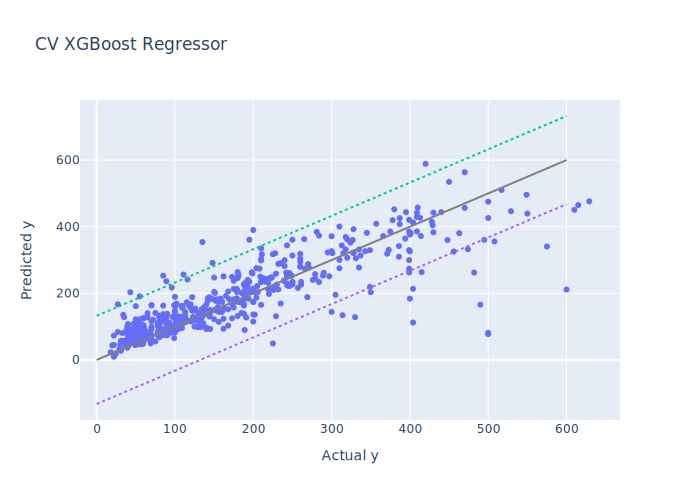

In [15]:
model = xgb.XGBRegressor(**cv.best_params_,).fit(X_train, y_train)
simulate(model, XXyy, 'CV XGBoost Regressor')

For XGBoost Regression, with parameters tuned, it is the best model, with R^2 score of 0.8 and RMSE score of 56.

Using Hyperopt-Sklearn, which is a wrapper of Hyperopt, a library for Distributed Asynchronous Hyper-parameter Optimization.

100%|██████████| 20/20 [00:01<00:00,  1.18s/trial, best loss: 0.3225125182194798]
Train
 Score: 0.7851404927633587
R2 Score 0.7851404927633587
RMSE : 61.762195834063334
Test
 Score: 0.683841430060773
R2 Score 0.683841430060773
RMSE : 72.14529105779475


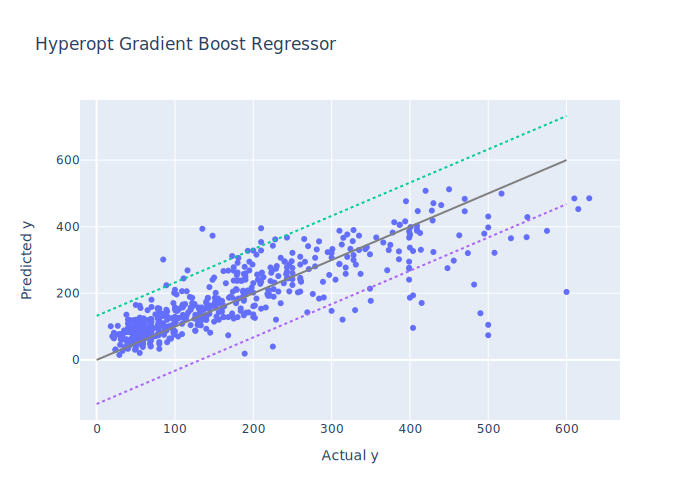

In [16]:
from hpsklearn import HyperoptEstimator, hist_gradient_boosting_regressor, xgboost_regression
from hyperopt import tpe

model = HyperoptEstimator(
    regressor=hist_gradient_boosting_regressor('HGBR'),
    preprocessing=[],
    algo=tpe.suggest,
    max_evals=20,
    n_jobs=-1,
    seed=random_state)
model.fit(X_train, y_train)

simulate(model, XXyy, 'Hyperopt Gradient Boost Regressor')

100%|██████████| 10/10 [00:06<00:00,  6.38s/trial, best loss: 0.2571314349378814]
Train
 Score: 0.9340761129135087
R2 Score 0.9340761129135087
RMSE : 34.21108467216202
Test
 Score: 0.7191194507360041
R2 Score 0.7191194507360041
RMSE : 68.00116348512601


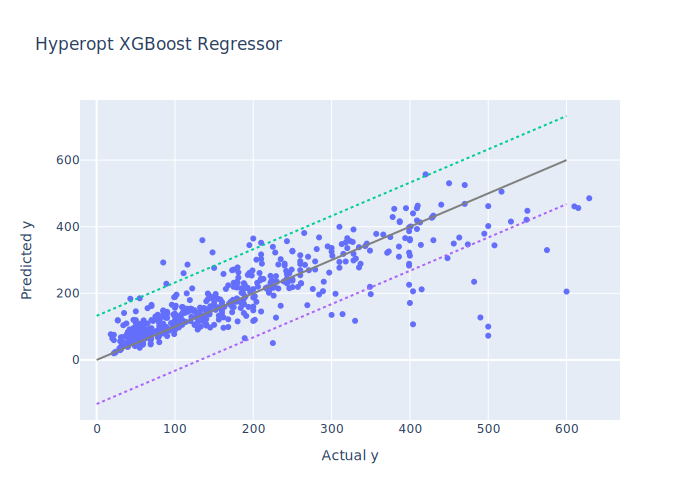

In [17]:
model = HyperoptEstimator(
    regressor=xgboost_regression('XGBR'),
    preprocessing=[],
    algo=tpe.suggest,
    max_evals=10,
    n_jobs=-1,
    seed=random_state)
model.fit(X_train, y_train)

simulate(model, XXyy, 'Hyperopt XGBoost Regressor')

From the optimization results above, we can see that achieving ~63 RMSE, ~0.75 $R^2$ is the best result we can get, the improvement is marginal.

From the plots and the RMSE, $R^2$ values, we can see that the prediction runs well when $0 \leq price \leq 220$ and as the price increases past 400, the price prediction is significantly further actual price. One reason for this would be that the listing is inaccurate, as not all listings in the dataset are successfully rented, the price of the rental house is artifically increased while providing no other benefits from houses with similiar 'criterias'. Another reason would be that any speciality of the house, like renovation, is only observable through listing picture and cannot be analyzed numerically or categorically. Further improvements can be made if we attempt to anaylze listing description using sentiment analysis etc.

In [18]:
# Save for analysis
pd.DataFrame(result).to_csv('data/model_results.csv')

In [21]:
observartion = pd.read_csv('data/model_results.csv', index_col=0)
obs_RMSE = observartion.sort_values(by='Test RMSE', ascending=False)
obs_R2 = observartion.sort_values(by='Test R2')

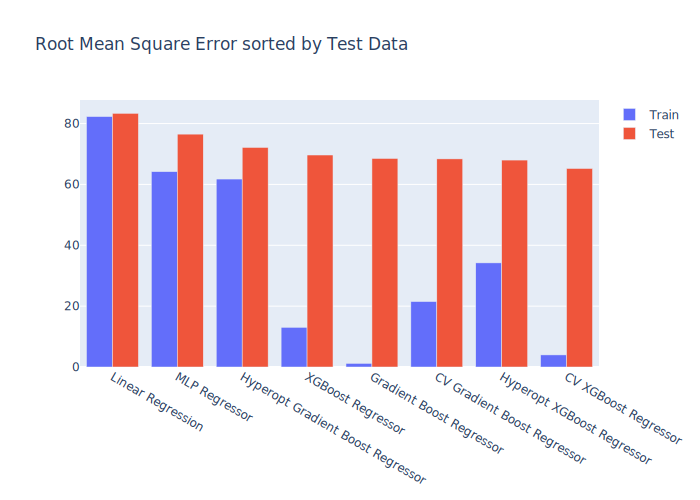

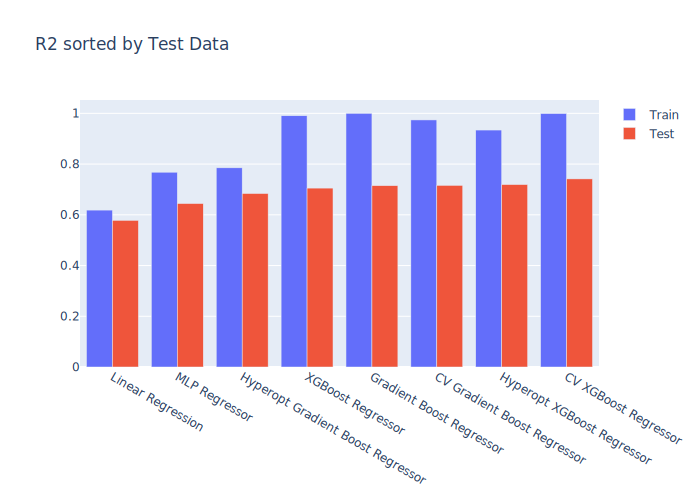

In [22]:
fig = go.Figure(data=[
        go.Bar(name='Train', x=obs_RMSE['Method'], y=obs_RMSE['Train RMSE']),
        go.Bar(name='Test', x=obs_RMSE['Method'], y=obs_RMSE['Test RMSE'])
    ], layout={'title': 'Root Mean Square Error sorted by Test Data'})
fig.show(render)
fig.write_image('images/RMSE Analysis.png', **image_output_params)

fig = go.Figure(data=[
        go.Bar(name='Train', x=obs_R2['Method'], y=obs_R2['Train R2']),
        go.Bar(name='Test', x=obs_R2['Method'], y=obs_R2['Test R2'])
    ], layout={'title': 'R2 sorted by Test Data'})
fig.show(render)
fig.write_image('images/R2 Analysis.png', **image_output_params)